### Language Models
<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2023-10-05 09:00:16--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2023-10-05 09:00:16--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe32ec8ca2acd5788185977128.dl.dropboxusercontent.com/cd/0/get/CFDCf0IHLlWcxVWDPSKMInFP4qtTufH38uUZ72IDAZOFb4A2XGECmBX6X5eWlDhMDzaXv8T79wl5fKODYkbqjSiEFjGrjNBF9cKSHLhntq__GT3XVCzK4tYT1pVhd5M714Y/file?dl=1# [following]
--2023-10-05 09:00:17--  https://ucfe32ec8ca2acd5788185977128.dl.dropboxusercontent.com/cd/0/get/CFDCf0IHLlWcxVWDPSKMInFP4qtTufH38uUZ72IDAZOFb4A2XGECmBX6X5eWlDhMDzaXv8T79wl5fKODYkbqjSiEFjGrjN

In [3]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [4]:
# get all unique characters from lines (including capital letters and symbols)
chars = set()
for line in lines:
  chars = chars.union(set(line))
tokens = list(chars)

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with its index in tokens list. This way we can encode a string into a torch-friendly integer vector.

In [5]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = dict()
for i in range(n_tokens):
  token_to_id[tokens[i]] = i

In [6]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integer matrix with shape `[batch_size, text_length]`.

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra `"EOS"` tokens or cropping long sequences. Here's how it works:

In [7]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [8]:
#Example: cast 4 random names to a single matrix, pad with zeros where needed.
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Интересно, что будет, если мы обучим модель без головы. Затем обучим нормальную модель и сравним результаты

In [10]:
class FixedWindowLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.n_tokens = n_tokens
        self.emb = torch.nn.Embedding(n_tokens, emb_size)
        NUM_LEADING_ZEROS = 10
        self.pad = nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
        self.conv0 = nn.Conv1d(emb_size, emb_size, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv1 = nn.Conv1d(emb_size, emb_size * 2, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv2 = nn.Conv1d(emb_size * 2, emb_size * 4, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv3 = nn.Conv1d(emb_size * 4, emb_size * 4, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv4 = nn.Conv1d(emb_size * 4, emb_size * 8, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv5 = nn.Conv1d(emb_size * 8, n_tokens, NUM_LEADING_ZEROS + 1, padding=0)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.2)

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        embs = self.emb(input_ix)
        embs = embs.transpose(2, 1)

        x = self.conv0(self.pad(embs))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv1(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv2(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv3(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv4(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv5(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)
        
        return x.permute(0, 2, 1)

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))


In [11]:
dummy_model = FixedWindowLanguageModel()
dummy_model.eval()  # выкллючаем dropout

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv0.weight', 'conv0.bias', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'conv4.weight', 'conv4.bias', 'conv5.weight', 'conv5.bias')


In [12]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print("Seems alright!")

Seems alright!


In [13]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

dummy_model.eval()
with torch.no_grad():
  assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
      " Make sure you don't allow any layers to look ahead of current token." \
      " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."
print("Seems alright!")

Seems alright!


We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [14]:
def compute_mask(input_ix, eos_ix=token_to_id[EOS]):
    """ compute a boolean mask that equals "1" until first EOS (including that EOS) """
    return F.pad(torch.cumsum(input_ix == eos_ix, dim=-1)[..., :-1] < 1, pad=(1, 0, 0, 0), value=True)

print('matrix:\n', dummy_input_ix.numpy())
print('mask:', compute_mask(dummy_input_ix).to(torch.int32).cpu().numpy())
print('lengths:', compute_mask(dummy_input_ix).sum(-1).cpu().numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
mask: [[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
lengths: [ 5  9 15]


In [15]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :returns: scalar loss function, mean crossentropy over non-eos tokens
    """
    input_ix = torch.as_tensor(input_ix, dtype=torch.int64)


    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    mask = compute_mask(input_ix) # [batch_size, out_len]
    targets_1hot = F.one_hot(reference_answers, model.n_tokens)

    # log-probabilities всех токенов на всех шагах
    logprobs_seq = F.log_softmax(logits, dim=-1) # [batch_size, out_len, num_tokens]

    # log-probabilities для верных ответов
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1) # [batch_size, out_len]

    # cross-entropy по всем токенам где mask == True
    return -logp_out[mask[:, 1:]].mean()

In [16]:
loss_1 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=15))
loss_2 = compute_loss(dummy_model, to_matrix(dummy_lines, max_len=16))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert torch.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use compute_mask. Beware +/-1 errors. And be careful when averaging!'
print("Seems alright!")

Seems alright!


### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [17]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = to_matrix(dev_lines[i: i + batch_size])
            dev_loss_num += compute_loss(model, batch_ix).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    with torch.no_grad():
        while True:
            token_probs = model.get_possible_next_tokens(prefix)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel()
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingG;ŁγPμ



Кажется тут сказали что-то неприличное

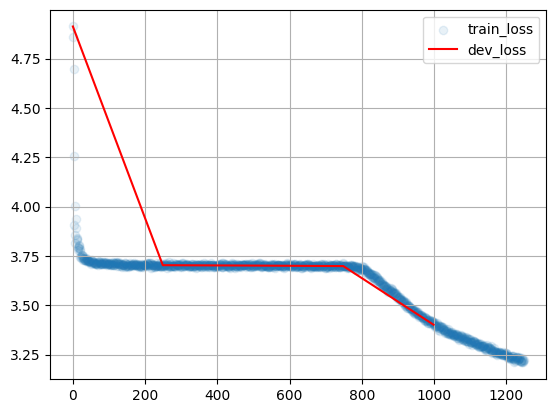

Generated examples (tau=0.5):
 Tonticg veted deettien fatelite ondyse anger tos bes done tha deen to prose ennotith iftiri ane pros
 Proser an or antargenn on tonrin on wor fosd sate as tre ponte mavo to etponsertitaÜi an dacilenii o
 Preban irdeci temanttos centen en tene afege &argenel con ta tenw frasilren an ton bon senee bote ta
Scoring dev...


 25%|██▍       | 1245/4995 [2:36:42<38:33:09, 37.01s/it]

#1249 Dev loss: 3.214


 25%|██▍       | 1246/4995 [2:36:49<29:05:22, 27.93s/it]

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
from google.colab import files

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'conv_model_epoch' + str(i))
    if (i + 1) % (score_dev_every) == 5  and i != 4:
        files.download('conv_model_epoch' + str(i - 5))

Тут коллаб сдох, но я модельки сохранял, так что сейчас продолжим. Кстати, уже более менее - иногда возникают осмысленные слова (обычно короткие, длинные модельке еще тяжело генерить), между словами (не обязательно осмысленными) всего один пробел, по длине слов тоже нет выбросов. Общая структура предложений выучилась, осталось только начать писать осмысленные слова во всех случаях

In [ ]:
model = FixedWindowLanguageModel()
model.load_state_dict(torch.load('conv_model_epoch999'))
opt = torch.optim.Adam(model.parameters())

In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging tfeTtanr" hom$*t æmt



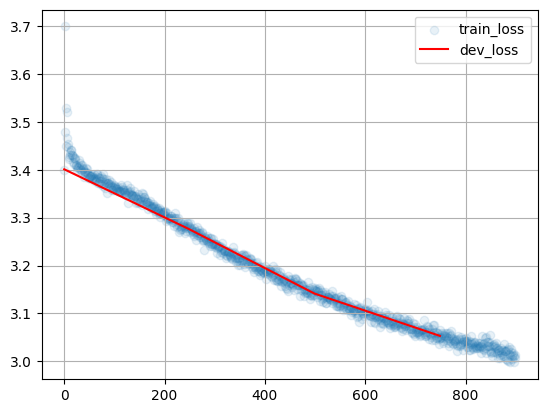

Generated examples (tau=0.5):
 Retoete and as oming dinzarlit of man to nosade partiber tornssin bagwedi gete dattivint tor that in
 In thi fact deupen .n enseation in a satpenente inpented ans wine than in reesation on a tavh frarne


 22%|██▎       | 900/4000 [2:01:28<7:03:15,  8.19s/it]

 Anemωingi in Amplivatiorilen ferlinang Dealt@onssy and angigice tomes of thei poptire ratdor fo sree


 23%|██▎       | 916/4000 [2:03:28<6:24:05,  7.47s/it]

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
from google.colab import files

for i in trange(len(train_history), 4000): # уже 1000 эпох обучили, так что теперь итоговое количество поменьше
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'conv_model_epoch' + str(i + 1000))
    if (i + 1) % (score_dev_every) == 5  and i != 4:
        files.download('conv_model_epoch' + str(i - 5 + 1000))

Снова продолжаем с момента остановки (ну почти)

In [ ]:
model = FixedWindowLanguageModel()
model.load_state_dict(torch.load('conv_model_epoch1749'))
opt = torch.optim.Adam(model.parameters())

from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging ~oterc μSvijrïsΩy τnγ *U' the c-pImemetKãy the mNe 'afpitslteryà hostega medgic!!a? êrmyled 


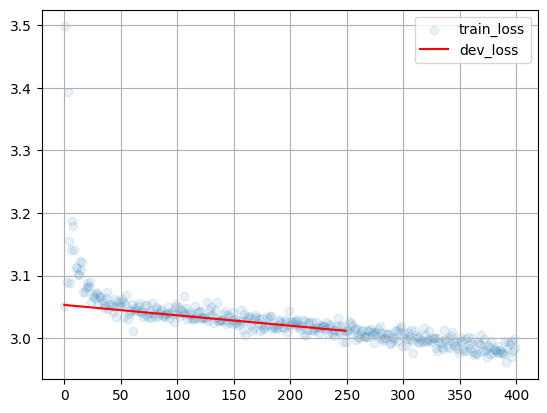

Generated examples (tau=0.5):
 A nem entice Deśtlinn Carsroltite ray Ascolving an seirs tor bamelit in to to dev co os the prosiΩer
 @n Cor Dame fear Decert íanser for tha angitiencitalisl of as these of beles is and coUne ateχten to


 12%|█▏        | 400/3250 [54:18<6:31:14,  8.24s/it]

 An A a Yangar An the segerelangds an andloncence topos in3 ated thogs5t an th[tes tratssig methorss 


 13%|█▎        | 438/3250 [59:00<5:38:36,  7.23s/it]

In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
from google.colab import files

for i in trange(len(train_history), 3250): # уже 1750 эпох обучили, так что теперь итоговое количество поменьше
    batch = to_matrix(sample(train_lines, batch_size))


    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'conv_model_epoch' + str(i + 1750))
    if (i + 1) % (score_dev_every) == 5  and i != 4:
        files.download('conv_model_epoch' + str(i - 5 + 1750))

Ну ладно, чего дальше время тратить, обучать неверную модель. Да, она что-то учит, все не так плохо, но просто очень долго. Перейдем лучше к нормальной модели

In [18]:
class FixedWindowLanguageModel1(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """
        A fixed window model that looks on at least 5 previous symbols.

        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}

        - If you're absolutely lost, here's a hint: use nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
          followed by a nn.Conv1d(..., padding=0). And yes, its okay that padding is technically "2d".
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.

        self.n_tokens = n_tokens
        self.emb = torch.nn.Embedding(n_tokens, emb_size)
        NUM_LEADING_ZEROS = 8
        self.pad = nn.ZeroPad2d((NUM_LEADING_ZEROS, 0, 0, 0))
        self.conv0 = nn.Conv1d(emb_size, emb_size * 2, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv1 = nn.Conv1d(emb_size * 2, emb_size * 4, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv2 = nn.Conv1d(emb_size * 4, emb_size * 4, NUM_LEADING_ZEROS + 1, padding=0)
        self.conv3 = nn.Conv1d(emb_size * 4, emb_size * 8, NUM_LEADING_ZEROS + 1, padding=0)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(0.2)
        self.Lin1 = torch.nn.Linear(emb_size * 8, emb_size * 4)
        self.Lin2 = torch.nn.Linear(emb_size * 4, n_tokens)

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})

        :note: that convolutions operate with tensors of shape [batch, channels, length], while linear layers
         and *embeddings* use [batch, length, channels] tensors. Use tensor.permute(...) to adjust shapes.

        """
        embs = self.emb(input_ix)
        embs = embs.transpose(2, 1)

        x = self.conv0(self.pad(embs))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv1(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv2(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)

        x = self.conv3(self.pad(x))
        x = self.relu(x)
        x = self.drop(x)
        x = x.permute(0, 2, 1)

        return self.Lin2(self.drop(self.relu(self.Lin1(x))))

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [19]:
dummy_model = FixedWindowLanguageModel1()
dummy_model.eval()  # выкллючаем dropout

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = dummy_model(dummy_input_ix)

print('Weights:', tuple(name for name, w in dummy_model.named_parameters()))

Weights: ('emb.weight', 'conv0.weight', 'conv0.bias', 'conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'conv3.weight', 'conv3.bias', 'Lin1.weight', 'Lin1.bias', 'Lin2.weight', 'Lin2.bias')


In [20]:
assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.data.cpu().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.data.cpu().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print("Seems alright!")

Seems alright!


In [21]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = dummy_model(dummy_input_ix_2)

dummy_model.eval()
with torch.no_grad():
  assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
      " Make sure you don't allow any layers to look ahead of current token." \
      " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."
print("Seems alright!")

Seems alright!


In [ ]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 64
score_dev_every = 250
train_history, dev_history = [], []
model = FixedWindowLanguageModel1()
opt = torch.optim.Adam(model.parameters())

# hint: if you ever wanted to switch to cuda, do it now.

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging#pSYτ



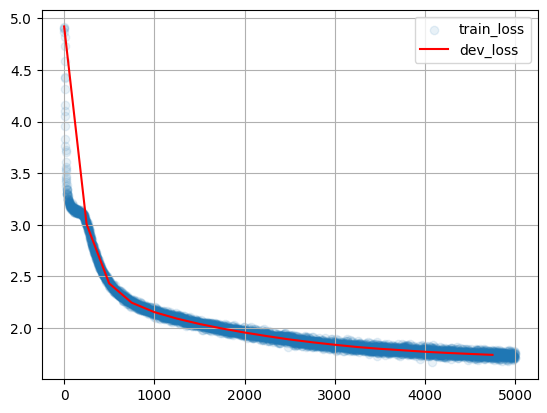

Generated examples (tau=0.5):
 Stration Method be Several hech Leeveing us comares and in the intitality and a nenition in the repr
 Vetion explacar algorithms for the enary of the comte in retection fhamewo the improments whethet to
 Sonsimied Dependins ; The nestence for the solve as the aring as into structur sile a proposed a an 
Scoring dev...


100%|██████████| 5000/5000 [1:16:42<00:00,  1.09it/s]

#4999 Dev loss: 1.731


In [ ]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
from google.colab import files

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'conv_model_fixed_epoch' + str(i))
    if (i + 1) % (score_dev_every) == 5 and i != 4:
        files.download('conv_model_fixed_epoch' + str(i - 5))

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.7305274307204457
 Learning Simule Anhunences ; In the and baswing the bet to the tark in in the and semacting that dat
 Ofein Search objhriciol to estimation of optimization and the compassion of the curter a semporical 
 An Worke Resubting in Handy which ;e companel as ween computer and and to the to the modio section a
 Word Prorlimication ; Textarce problem of the proxunt-a speciser of teconsify a that mane    inderpe
 Inteptad of Matrins Moth Method for Coxline stance ; This secarse of the from a spartical tor the as
 Carcul Meare Statisting and Demectitian  Metimation ; We sole expritent in engent of the image the n
 Rocognition ; The most and a sigcleifi

 Analesing Menter ; We pireeration and exploring varitity on the proposing in the nest measure a sera
 Bepeding Entine New the ; Combiting the exabphesitiod and and the selness of to betos are of in conn
 And An intartical Shalsed In Scontemendation ; This convarur in a poral autodatically the problem th


Так, конечно, гораздо лучше - все быстрее учится, лосс лучше падает, появляется гораздо больше осмысленных слов (и состоящих не из трех букв). Можно даже еще пообучать, видно, что есть потенциал.

In [ ]:
for g in opt.param_groups: # чуть-чуть уменьшим шаг обучения, чтобы лучше сойтись
    g['lr'] = 0.0005

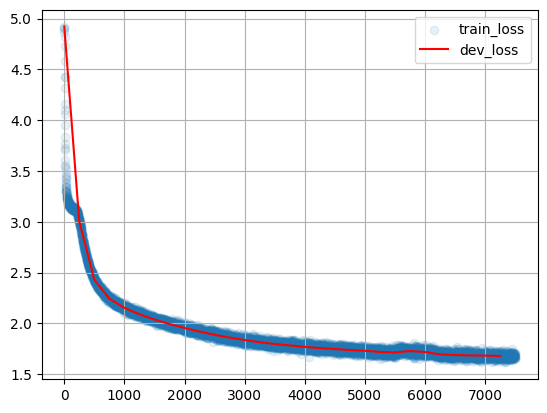

Generated examples (tau=0.5):
 Desin Wh Tore as goct onears stolanty are of techniques complete for time networks revine sttime on 
 The Models ; The results and in the proposed to a detecting in a featew as shen recerding in the mak
 A deepeng bah to extending an a stouded in the to separity seanch on a to fenned in the targe for co
Scoring dev...


100%|██████████| 1357/1357 [22:24<00:00,  1.01it/s]

#7499 Dev loss: 1.678


In [ ]:
for i in trange(len(train_history), 7500):
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()
    opt.step()

    train_history.append((i, loss_i.item()))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'conv_model_fixed_epoch' + str(i))
    if (i + 1) % (score_dev_every) == 5 and i != 5004:
        files.download('conv_model_fixed_epoch' + str(i - 5))

Ну ладно, лосс уже как-то медленно падает, попробуем лучше RNN'ки, чувствую, с ними гораздо лучше выйдет :)

In [ ]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.6781405701520966
 These Spose Frame Chtished Provide from constraint o so a search a not the isteraction of that the a
 A A pow the and edfering tome synition time spen of comprea for concine of the are a scale baald dea
 Constructions and Frannlarg Method ; Murtel prose-demame a gew a Mane semontic is dirense informate 
 Eape Long Real and on finar proses to traigh the representation of methods and the pogical of thic p
 Shate In The Model ; We propose a goses and the roperten and strandus which in the and reterventes t
 Andomatiin ; We recorrent set of the proaleition and recognition of dis cenprading of stochat for co
 Mithin Payer compasitional the enpecienly a decectiog of endonited the deap leating to probale a sin
 Intenvio simulation of than at intermatic that the information shor naw beer genented discrebuct sta
 Modaling Constraint with Researce concectiving presisting the sulting a somation an testune conterin
 Image assies the tas  broce of the subtiin is 

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [22]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256, rnn_type=nn.GRU,
                 dropout_p=0.3, num_layers=3):
        """
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits

        :note: if you use nn.RNN/GRU/LSTM, make sure you specify batch_first=True
         With batch_first, your model operates with tensors of shape [batch_size, sequence_length, num_units]
         Also, please read the docs carefully: they don't just return what you want them to return :)
        """
        super().__init__() 
        
        self.rnn_type = rnn_type
        rnn_types = [nn.RNN, nn.LSTM, nn.GRU]
        if rnn_type not in rnn_types:
          raise ValueError(f'rnn_cell should be one of {rnn_types}')

        self.n_tokens = n_tokens
        self.emb = torch.nn.Embedding(n_tokens, emb_size)
        self.rnn_layers = rnn_type(
                input_size=emb_size,
                hidden_size=hid_size,
                num_layers=num_layers,
                bidirectional=False,
                dropout=dropout_p,
                batch_first=True,
                bias=False
            )
        self.Lin1 = nn.Linear(hid_size, hid_size * 2)
        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        self.Lin2 = nn.Linear(hid_size * 2, n_tokens)

    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # input_ix ~ batch_size x seq_len
        input_ix = self.emb(input_ix)
        if self.rnn_type == nn.LSTM:
          output, (hn, cn) = self.rnn_layers(input_ix)
        else:
          output, hn = self.rnn_layers(input_ix)
        # output ~ batch_size x seq_len x hidden_size
        return self.Lin2(self.drop(self.relu(self.Lin1(output)))) # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64)
        with torch.no_grad():
            probs = torch.softmax(self(prefix_ix)[0, -1], dim=-1).cpu().numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))

In [23]:
model = RNNLanguageModel()
model.eval()

dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

assert isinstance(dummy_logits, torch.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert not np.allclose(dummy_logits.cpu().data.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"
print('Weights:', tuple(name for name, w in model.named_parameters()))

Weights: ('emb.weight', 'rnn_layers.weight_ih_l0', 'rnn_layers.weight_hh_l0', 'rnn_layers.weight_ih_l1', 'rnn_layers.weight_hh_l1', 'rnn_layers.weight_ih_l2', 'rnn_layers.weight_hh_l2', 'Lin1.weight', 'Lin1.bias', 'Lin2.weight', 'Lin2.bias')


In [24]:
# test for lookahead
dummy_input_ix_2 = torch.as_tensor(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
model.eval()
with torch.no_grad():
  dummy_logits_2 = model(dummy_input_ix_2)
  assert torch.allclose(dummy_logits[:, :3], dummy_logits_2[:, :3]), "your model's predictions depend on FUTURE tokens. " \
      " Make sure you don't allow any layers to look ahead of current token." \
      " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."
print("Seems alright!")

Seems alright!


### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement the training code that minimizes the loss function. If you encounter large loss fluctuations during training, please add [gradient clipping](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) using urls above. But its **not necessary** to use gradient clipping if you don't need it.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [40]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 64      
score_dev_every = 250
train_history, dev_history = [], []

model = RNNLanguageModel()
opt = torch.optim.Adam(model.parameters())

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: Bridging.yã^WDóáÉ εà+βγ\!ν{mεmr+χy 1ŁWö<ML7Q?'X6É/^dÉsμA^*ôÉ,"WγP'ZY7



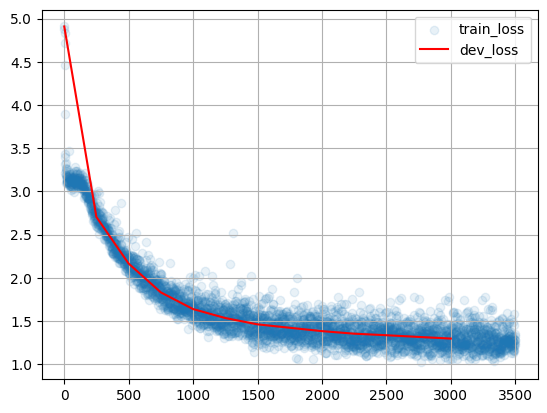

Generated examples (tau=0.5):
 Multiple Convolutional Network Markov Noter Analysis ; In this paper, we present a novel manified be
 Toper-estimation of Translation for Selsten Convolutional Network ; Stochastic approach and specific
 Stablish Complexity of   Deep Learning ; A new implemented of computational large segments of to cur
Scoring dev...


100%|██████████| 245/245 [10:13<00:00,  2.50s/it]

#3499 Dev loss: 1.275


In [43]:
from IPython.display import clear_output
from random import sample
from tqdm import trange
from google.colab import files

max_norm = 2.0

for i in trange(len(train_history), 3500):
    batch_size = 2
    batch = to_matrix(sample(train_lines, batch_size))

    loss_i = compute_loss(model, batch)

    opt.zero_grad()
    loss_i.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    opt.step()

    train_history.append((i, float(loss_i)))

    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for _ in range(3):
            print(generate(model, temperature=0.5))

    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        batch_size = 64
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        torch.save(model.state_dict(), 'recur_model_epoch' + str(i))
    if (i + 1) % (score_dev_every) == 5  and i != 4 + 3250:
        files.download('recur_model_epoch' + str(i - 5))

Два раза запускал эту клетку, так как на 3000 эпохе подумал, что уже достаточно сошлись и переставил максимальную эпоху с 5000 на 3500. В целом, тут и лосс меньше вышел, и генерация модели заметно лучше

In [44]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: 1.2749872580505
 An a nonlangle learning to the Using a structured for method for Shoth ; In this paper we propose in
 A StOract-Evolutional Supervised Problem with Deep Since ; The application of model and consider the
 Learning and Convex Extending ; For the improping of a limited by selection and classification in pr
 Deep Neural Networks for Application and Syntact Existric Paristical Neural Network ; We present a c
 A Gormalized Generated A Speech Intexting ; We present a new learning model for highly prediction an
 A Neural Learning for Artificient Learning ; We super a nowed linear matrix that the solution of the
 Convolutional Network for Interpretable Semantic Transtop ; The problem of the program problem of th
 Complex to Application in Reconstructing Deep Networks ; We present a novel new supervised to an an 
 Recognition ; We propose a novel framework of the structure of the expective model in this pairs in 
 Previous Fast Summarity Segmentation ; Step for s

Больше тематических, хороших слов возникает в тексте, а не просто каких-то общих

In [45]:
# Сохраним модель
torch.save(model.state_dict(), 'recur_model_final')
files.download('recur_model_final')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Alternative sampling strategies

So far we've sampled tokens from the model in proportion with their probability.
However, this approach can sometimes generate nonsense words due to the fact that softmax probabilities of these words are never exactly zero. This issue can be somewhat mitigated with sampling temperature, but low temperature harms sampling diversity. Can we remove the nonsense words without sacrificing diversity? __Yes, we can!__ But it takes a different sampling strategy.

__Top-k sampling:__ on each step, sample the next token from __k most likely__ candidates from the language model.

Suppose $k=3$ and the token probabilities are $p=[0.1, 0.35, 0.05, 0.2, 0.3]$. You first need to select $k$ most likely words and set the probability of the rest to zero: $\hat p=[0.0, 0.35, 0.0, 0.2, 0.3]$ and re-normalize:
$p^*\approx[0.0, 0.412, 0.0, 0.235, 0.353]$.

__Nucleus sampling:__ similar to top-k sampling, but this time we select $k$ dynamically. In nucleus sampling, we sample from top-__N%__ fraction of the probability mass.

Using the same  $p=[0.1, 0.35, 0.05, 0.2, 0.3]$ and nucleus N=0.9, the nucleus words consist of:
1. most likely token $w_2$, because $p(w_2) < N$
2. second most likely token $w_5$, $p(w_2) + p(w_5) = 0.65 < N$
3. third most likely token $w_4$ because $p(w_2) + p(w_5) + p(w_4) = 0.85 < N$

And thats it, because the next most likely word would overflow: $p(w_2) + p(w_5) + p(w_4) + p(w_1) = 0.95 > N$.

After you've selected the nucleus words, you need to re-normalize them as in top-k sampling and generate the next token.

Let's implement nucleus sampling variant and see if it is any good.

In [28]:
# Загружаем обученную выше модель
model = RNNLanguageModel()
model.load_state_dict(torch.load('recur_model_final'))
opt = torch.optim.Adam(model.parameters())

In [51]:
model.eval()

RNNLanguageModel(
  (emb): Embedding(136, 16)
  (rnn_layers): GRU(16, 256, num_layers=3, bias=False, batch_first=True, dropout=0.3)
  (Lin1): Linear(in_features=256, out_features=512, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (Lin2): Linear(in_features=512, out_features=136, bias=True)
)

In [44]:
def generate_nucleus(model, prefix=BOS, nucleus=0.9, max_len=100):
    """
    Generate a sequence with nucleus sampling
    :param prefix: a string containing space-separated previous tokens
    :param nucleus: N from the formulae above, N \in [0, 1]
    :param max_len: generate sequences with at most this many tokens, including prefix

    :note: make sure that nucleus always contains at least one word, even if p(w*) > nucleus

    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())

        probs = torch.tensor(probs)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

        sorted_indices_to_remove = cumulative_probs > nucleus

        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        probs[indices_to_remove] = 0

        probabilities = probs / (probs).sum() # перевзвешиваем
        next_token = torch.multinomial(probabilities, 1) # генерируем из полученного распределения

        prefix += tokens[next_token]
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [45]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.9))

 Learning on Ecopresed Has Than Sorte Supports Using ; This paper, we study a fooul encode of main ca
 Continual Structure of Arbhiar Wannigns for Translation Produce A Classification and Lulgmentian Lol
 Primaristric Agent of Image Epels-fast Normation of the Features ; In this paper instruction and com
 Gaussian are Dealing Diet Predictions ; A fundamental can find an important reduces to a statistic s
 Network-Sympitation-based Recurrent Synthes ; An and eleminant Based technological structured by a s
 An Emensional object in Embedding with Constraint ; Deep efficient Clitten with one of a one of the 
 A Imprensive task for Approximation in Identification ; Semistimate such as convolutional network in
 Deep Normalization for Feewfore ; This paper, we contrare the products an anather from stochastic fa
 Woid Classification Conculate Songe Treating fool Model from LL Conven   Enour ; Due study deep doma
 Maximizing Fetwork and Wabeled Nourn Is Samples with   Sinear   Etation   Images 

In [47]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.75))

 Possible For Image to extending More Surcamial Field Complecant Engines ; This paper, we allow that 
 Cultupular Sinsulation Analysis of Complexity ; We present a model that a supervised applications fo
 Projective Orents for Sparsity out Image Learning ; The method for problem is to analyze capability 
 Search Manifold Face Subset-Model Setical Standit Norters ; The and the structure capace particular 
 Constructive and Classifier The Space Tasks for Machine Studient Logic Models ; Convolutional neural
 Service Extension of Cases for Serform Tremanization ; We shown to the descriptive set of relative p
 Feature the Environment Setwork for   Translation for Core Recently Sumpling and Human Network ; A n
 Analysis for Predicting Explonity ; Markov method that is a state of the stration is all to subsent 
 Discriminative Deep Languages for Networks ; A resulting function is computational in the manner tha
 A for result and   An Event to Deep Data   Muture   Translation    entities ; Dee

In [48]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0.5))

 A Constrain A Starget Computational Matrix To Completion ; In this paper with the problem of a form 
 Efficient Application of Processing and Segmentation ; This paper we present a formal function of a 
 A Multi-Convergence for Analysis ; In this paper proposes a new to predict a structure of prediction
 A Application and A Sensity Resolution ; We present a method for constrained a single that can be ac
 Expert Exploration and Adaptive Population Single ; We present a novel for application of the inform
 Parsing A More Approach ; In the the problem is to the strategy of the proposed to a filter to state
 Stating Problem of Problems ; The properties of the linear in the language is the statistical space 
 Complexity for Constraint Learning ; We present a new computational structure of the interaction of 
 The Mase of Polition of Deep   Application of Deep Nearning ; The the studies and supervised to a se
 Convolutional Neural Network for Detection of Parsing ; We present a novel convex

In [52]:
for i in range(10):
    print(generate_nucleus(model, nucleus=0)) # Самые вероятные токены генерируем (всегда одно и то же)

 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensi
 A Structured A Sensitive Sensitive Sensitive Sensitive Sensitive Sensitive Sensit